# Image classification using RNN and CNN

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
#from google.colab import files

Name:  Santiago Morales S.

## Data

In [ ]:
(x_train,y_train),(x_test,y_test)=cifar100.load_data()
x_train=x_train/255
x_test=x_test/255

 60809216/169001437 [=========>....................] - ETA: 4:11

In [ ]:
y_trainOH = np.zeros([y_train.shape[0],100])
y_testOH = np.zeros([y_test.shape[0],100])
y_trainOH[np.arange(y_train.shape[0]),y_train.reshape(-1)]=1
y_testOH[np.arange(y_test.shape[0]),y_test.reshape(-1)]=1

In [6]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


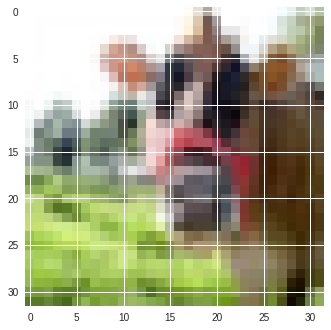

In [7]:
plt.imshow(x_train[0])

## Next Bach function CNN

In [0]:
def next_batchCNN(batch_size):
    t0 = np.random.randint(0,len(x_train),batch_size)
    xs = x_train[t0]
    ys = y_trainOH[t0]
    return xs, ys

In [8]:
a = np.random.randint(0,len(x_train),50)
xx = x_train[a]
yy = y_trainOH[a]
np.shape(yy.reshape(-1,100))
np.shape(yy)

(50, 100)

## Next Batch function RNN

In [0]:
def next_batchRNN(batch_size):
    t0 = np.random.randint(0,len(x_train),batch_size)
    xs = np.mean(x_train[t0],axis=3)
    ys = y_train[t0]
    return xs, ys.reshape(-1)

In [0]:
#a = np.random.randint(0,len(x_train),50)
#b = np.mean(x_train[a],axis=3)
#c = y_train[a]
#y_train[a]


# CNN

In [0]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, 32,32, 3))
y = tf.placeholder(tf.float32, shape=(None, 100))

convos=[64,32,384]
k_size=[3,1]
n_stride=1
pools=[2,2]


##CONVOLUTION 64-3x3
convo11 = tf.layers.conv2d(X, convos[1],kernel_size=k_size[0], strides=1, padding="VALID",activation=tf.nn.selu)

##CONVOLUTION 32-3x3
convo21 = tf.layers.conv2d(convo11, convos[0],kernel_size=k_size[0], strides=1, padding="VALID",activation=tf.nn.selu)

##POOLING 2x2
pool11 = tf.layers.max_pooling2d(convo21,pool_size=pools[0],strides=pools[0])


##CONVOLUTION 64-3x3
convo1 = tf.layers.conv2d(pool11, convos[0],kernel_size=k_size[0], strides=1, padding="SAME",activation=tf.nn.selu)

##POOLING 2x2
pool1 = tf.layers.max_pooling2d(convo1,pool_size=pools[0],strides=pools[0])

##INCEPTION
#1st layer
convo2 = tf.layers.conv2d(pool1, convos[0],kernel_size=k_size[1], strides=n_stride, padding="SAME",activation=tf.nn.selu)
convo3 = tf.layers.conv2d(pool1, convos[0],kernel_size=k_size[1], strides=n_stride, padding="SAME",activation=tf.nn.selu)
convo4 = tf.layers.conv2d(pool1, convos[0],kernel_size=k_size[1], strides=n_stride, padding="SAME",activation=tf.nn.selu)
#2nd layer
convo5 = tf.layers.conv2d(convo3, convos[0],kernel_size=k_size[0], strides=n_stride, padding="SAME",activation=tf.nn.selu)
convo6 = tf.layers.conv2d(convo4, convos[0],kernel_size=k_size[0], strides=n_stride, padding="SAME",activation=tf.nn.selu)
#3rd layer
convo7 = tf.layers.conv2d(convo6, convos[0],kernel_size=k_size[0], strides=n_stride, padding="SAME",activation=tf.nn.selu)
#Concat
concat = tf.concat([convo2,convo5,convo7],3)
convoInc = tf.layers.conv2d(concat, 64,kernel_size=k_size[1], strides=n_stride, padding="SAME",activation=tf.nn.selu)

##CONVOLUTION 32-3x3
convo12 = tf.layers.conv2d(convoInc, convos[0],kernel_size=k_size[1], strides=1, padding="VALID",activation=tf.nn.selu)

##CONVOLUTION 32-3x3
convo22 = tf.layers.conv2d(convo12, convos[0],kernel_size=k_size[1], strides=1, padding="VALID",activation=tf.nn.selu)

##POOLING 2x2
pool2 = tf.layers.average_pooling2d(convo22,pool_size=pools[1],strides=pools[1])


##DENSE 64
flat = tf.layers.flatten(pool2)
dense = tf.layers.dense(flat, 64,activation=tf.nn.selu)
logits = tf.layers.dense(dense, 100)
y_pred=tf.nn.softmax(logits)

xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.equal(tf.argmax(y,1),tf.argmax(y_pred,1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [57]:
saverCNN = tf.train.Saver()
n_epochs = 24
batch_size = 500
iters=len(x_train)//batch_size
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        acc_train=0
        for iteration in range(iters):
            X_batch, y_batch = next_batchCNN(batch_size)
            curr_acc,_=sess.run([accuracy,training_op], feed_dict={X: X_batch, y: y_batch})
            acc_train += curr_acc
        acc_test = accuracy.eval(feed_dict={X: x_test, y: y_testOH})
        print(epoch, "Train accuracy:", acc_train/iters, "Test accuracy:", acc_test)
    saverCNN.save(sess, "./ModelCNN")

0 Train accuracy: 0.08364000050816685 Test accuracy: 0.1528
1 Train accuracy: 0.19472000047564506 Test accuracy: 0.2254
2 Train accuracy: 0.28170000165700915 Test accuracy: 0.2798
3 Train accuracy: 0.3396800005435944 Test accuracy: 0.3211
4 Train accuracy: 0.37458000153303145 Test accuracy: 0.3529
5 Train accuracy: 0.4000399991869926 Test accuracy: 0.3616
6 Train accuracy: 0.42763999968767163 Test accuracy: 0.3688
7 Train accuracy: 0.4507799997925758 Test accuracy: 0.3854
8 Train accuracy: 0.46869999915361404 Test accuracy: 0.3995
9 Train accuracy: 0.4917799997329712 Test accuracy: 0.4153
10 Train accuracy: 0.5089399987459182 Test accuracy: 0.4159
11 Train accuracy: 0.521439998447895 Test accuracy: 0.4202
12 Train accuracy: 0.5369800013303757 Test accuracy: 0.4248
13 Train accuracy: 0.5589200013875961 Test accuracy: 0.4279
14 Train accuracy: 0.5683799993991852 Test accuracy: 0.4301
15 Train accuracy: 0.5824000000953674 Test accuracy: 0.4369
16 Train accuracy: 0.5916199988126755 Test ac

# RNN

In [58]:
tf.reset_default_graph()

n_steps = 32
n_inputs = 32
n_neurons = [50,50,50,100]
n_outputs = 100

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.int32, [None])


layers = [tf.contrib.rnn.GRUCell(num_units=n_neuron, activation=tf.nn.selu) for n_neuron in n_neurons]
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

states_concat = tf.concat(axis=1, values=states)
logits = tf.layers.dense(states_concat, n_outputs)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

n_epochs = 15
batch_size = 150
iters=len(x_train) // batch_size
saverRNN = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        acc_train=0
        for iteration in range(iters):
            X_batch, y_batch = next_batchRNN(batch_size)
            #X_batch = X_batch.reshape((-1, n_steps, n_inputs))
            curr_acc,_=sess.run([accuracy,training_op], feed_dict={X: X_batch, y: y_batch})
            acc_train += curr_acc
        acc_test = accuracy.eval(feed_dict={X: np.mean(x_test,axis=3), y: y_test.reshape(-1)})
        print(epoch, "Train accuracy:", acc_train/iters, "Test accuracy:", acc_test)
    saverCNN.save(sess, "./ModelRNN")


0 Train accuracy: 0.06734734757134954 Test accuracy: 0.0918
1 Train accuracy: 0.12212212302081578 Test accuracy: 0.1317
2 Train accuracy: 0.14998999020985296 Test accuracy: 0.1553
3 Train accuracy: 0.1766966975800268 Test accuracy: 0.1697
4 Train accuracy: 0.19395395473495977 Test accuracy: 0.1844
5 Train accuracy: 0.21179179269988258 Test accuracy: 0.1887
6 Train accuracy: 0.2259659664901169 Test accuracy: 0.2007
7 Train accuracy: 0.24464464572456865 Test accuracy: 0.2074
8 Train accuracy: 0.2582982986628472 Test accuracy: 0.2105
9 Train accuracy: 0.2753553555176423 Test accuracy: 0.2115
10 Train accuracy: 0.28726726819624054 Test accuracy: 0.2181
11 Train accuracy: 0.29669669758271167 Test accuracy: 0.2224
12 Train accuracy: 0.3126726721052651 Test accuracy: 0.2156
13 Train accuracy: 0.31971972053115433 Test accuracy: 0.2216
14 Train accuracy: 0.32904904919701655 Test accuracy: 0.2209
